In [1]:


from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm
import time
from torch.cuda.amp import GradScaler, autocast

In [3]:
#models = timm.list_models()
#for model in models:
#    print(model)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def load_data(directory, input_shape):
    x = []
    y = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (input_shape[1], input_shape[0]))
                x.append(image)
                y.append(class_name)
    x = np.array(x)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return x, y_encoded, label_encoder.classes_

input_shape = (408, 408, 3)
train_dir = '/content/drive/MyDrive/Chiro10/train_512'
test_dir = '/content/drive/MyDrive/Chiro10/test_512'
val_dir = '/content/drive/MyDrive/Chiro10/val_512'

x_train, y_train, classes = load_data(train_dir, input_shape)
x_test, y_test, _ = load_data(test_dir, input_shape)
x_val, y_val, _ = load_data(val_dir, input_shape)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((408, 408)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



train_dataset = CustomDataset(x_train, y_train, transform=transform)
test_dataset = CustomDataset(x_test, y_test, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vit_base_patch16_224 64 32 32
model = timm.create_model('crossvit_18_dagger_408', pretrained=False)
# Replace the last Linear layer
model.head[0] = nn.Linear(model.head[0].in_features, len(classes))
model.head[1] = nn.Linear(model.head[1].in_features, len(classes))

model = model.to(device)


criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))



model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)
evaluate_model(model, criterion, test_dataloader)
torch.save(model.state_dict(), '/content/drive/MyDrive/crossvit_18_dagger_408.pth')


x_train shape: (923, 408, 408, 3) - y_train shape: (923,)
x_test shape: (554, 408, 408, 3) - y_test shape: (554,)
x_val shape: (369, 408, 408, 3) - y_val shape: (369,)
Epoch 0/49
----------


100%|██████████| 29/29 [01:22<00:00,  2.83s/it]


train Loss: 2.4627 Acc: 0.1484


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


val Loss: 2.1986 Acc: 0.1816

Epoch 1/49
----------


100%|██████████| 29/29 [01:21<00:00,  2.81s/it]


train Loss: 2.1800 Acc: 0.1842


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


val Loss: 2.1040 Acc: 0.2141

Epoch 2/49
----------


100%|██████████| 29/29 [01:22<00:00,  2.84s/it]


train Loss: 2.0652 Acc: 0.2579


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


val Loss: 1.9486 Acc: 0.3279

Epoch 3/49
----------


100%|██████████| 29/29 [01:22<00:00,  2.85s/it]


train Loss: 1.9220 Acc: 0.2849


100%|██████████| 47/47 [00:09<00:00,  4.82it/s]


val Loss: 1.8523 Acc: 0.3469

Epoch 4/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


train Loss: 1.8034 Acc: 0.3532


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


val Loss: 1.7733 Acc: 0.3550

Epoch 5/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.7776 Acc: 0.3445


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 1.7502 Acc: 0.3740

Epoch 6/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.7375 Acc: 0.3694


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 1.7836 Acc: 0.3604

Epoch 7/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.7219 Acc: 0.3651


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


val Loss: 1.6957 Acc: 0.3631

Epoch 8/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.6791 Acc: 0.4204


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


val Loss: 1.6546 Acc: 0.4092

Epoch 9/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.6752 Acc: 0.3944


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


val Loss: 1.7275 Acc: 0.4119

Epoch 10/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.6972 Acc: 0.3965


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 1.6383 Acc: 0.3984

Epoch 11/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.6401 Acc: 0.4258


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


val Loss: 1.6131 Acc: 0.4634

Epoch 12/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.6072 Acc: 0.4334


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


val Loss: 1.6593 Acc: 0.4173

Epoch 13/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.6296 Acc: 0.4475


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 1.5848 Acc: 0.4390

Epoch 14/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.5649 Acc: 0.4724


100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


val Loss: 1.5264 Acc: 0.5041

Epoch 15/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.4980 Acc: 0.5211


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


val Loss: 1.4580 Acc: 0.5014

Epoch 16/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.4750 Acc: 0.5363


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


val Loss: 1.5488 Acc: 0.5122

Epoch 17/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.4473 Acc: 0.5374


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


val Loss: 1.4367 Acc: 0.5474

Epoch 18/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.3137 Acc: 0.5980


100%|██████████| 47/47 [00:09<00:00,  4.80it/s]


val Loss: 1.2642 Acc: 0.6341

Epoch 19/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.3123 Acc: 0.5980


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 1.2795 Acc: 0.6260

Epoch 20/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 1.2622 Acc: 0.6251


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


val Loss: 1.2653 Acc: 0.6396

Epoch 21/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.2370 Acc: 0.6457


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


val Loss: 1.2524 Acc: 0.6341

Epoch 22/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 1.2678 Acc: 0.6241


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


val Loss: 1.2928 Acc: 0.6450

Epoch 23/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.98s/it]


train Loss: 1.1683 Acc: 0.6815


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


val Loss: 1.1790 Acc: 0.7127

Epoch 24/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.98s/it]


train Loss: 1.1770 Acc: 0.6966


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


val Loss: 1.3208 Acc: 0.6260

Epoch 25/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


train Loss: 1.1812 Acc: 0.6717


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


val Loss: 1.1708 Acc: 0.7154

Epoch 26/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


train Loss: 1.1224 Acc: 0.7118


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


val Loss: 1.1436 Acc: 0.7127

Epoch 27/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


train Loss: 1.0741 Acc: 0.7216


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


val Loss: 1.1104 Acc: 0.7154

Epoch 28/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


train Loss: 1.0550 Acc: 0.7313


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 1.0309 Acc: 0.7778

Epoch 29/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


train Loss: 1.0156 Acc: 0.7671


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


val Loss: 1.0557 Acc: 0.7534

Epoch 30/49
----------


100%|██████████| 29/29 [01:25<00:00,  2.96s/it]


train Loss: 0.9893 Acc: 0.7681


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


val Loss: 1.0572 Acc: 0.7453

Epoch 31/49
----------


100%|██████████| 29/29 [01:25<00:00,  2.96s/it]


train Loss: 0.9987 Acc: 0.7660


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


val Loss: 1.1125 Acc: 0.7236

Epoch 32/49
----------


100%|██████████| 29/29 [01:25<00:00,  2.96s/it]


train Loss: 0.9810 Acc: 0.7801


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


val Loss: 1.0657 Acc: 0.7588

Epoch 33/49
----------


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


train Loss: 0.9668 Acc: 0.7757


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


val Loss: 1.0236 Acc: 0.7832

Epoch 34/49
----------


100%|██████████| 29/29 [01:25<00:00,  2.94s/it]


train Loss: 0.9235 Acc: 0.7996


100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


val Loss: 1.0492 Acc: 0.7534

Epoch 35/49
----------


100%|██████████| 29/29 [01:24<00:00,  2.90s/it]


train Loss: 0.9471 Acc: 0.7866


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


val Loss: 1.2706 Acc: 0.6396

Epoch 36/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 0.9710 Acc: 0.7887


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 0.9632 Acc: 0.7967

Epoch 37/49
----------


100%|██████████| 29/29 [01:24<00:00,  2.90s/it]


train Loss: 0.8922 Acc: 0.8191


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


val Loss: 0.9730 Acc: 0.7940

Epoch 38/49
----------


100%|██████████| 29/29 [01:24<00:00,  2.90s/it]


train Loss: 0.9165 Acc: 0.8061


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 0.9926 Acc: 0.7886

Epoch 39/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 0.8963 Acc: 0.8180


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


val Loss: 0.9531 Acc: 0.8049

Epoch 40/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 0.8693 Acc: 0.8353


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 0.9868 Acc: 0.7859

Epoch 41/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 0.8886 Acc: 0.8093


100%|██████████| 47/47 [00:09<00:00,  4.76it/s]


val Loss: 0.9355 Acc: 0.7859

Epoch 42/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 0.8172 Acc: 0.8613


100%|██████████| 47/47 [00:10<00:00,  4.66it/s]


val Loss: 0.9595 Acc: 0.8022

Epoch 43/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 0.7979 Acc: 0.8841


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


val Loss: 1.0134 Acc: 0.7913

Epoch 44/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


train Loss: 0.8167 Acc: 0.8646


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


val Loss: 0.9381 Acc: 0.8293

Epoch 45/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


train Loss: 0.7583 Acc: 0.8884


100%|██████████| 47/47 [00:09<00:00,  4.73it/s]


val Loss: 0.9105 Acc: 0.8130

Epoch 46/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


train Loss: 0.7730 Acc: 0.8797


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


val Loss: 0.9807 Acc: 0.7805

Epoch 47/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


train Loss: 0.7936 Acc: 0.8808


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


val Loss: 0.9066 Acc: 0.8428

Epoch 48/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


train Loss: 0.7408 Acc: 0.9025


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


val Loss: 0.9821 Acc: 0.8076

Epoch 49/49
----------


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


train Loss: 0.8270 Acc: 0.8700


100%|██████████| 47/47 [00:09<00:00,  4.81it/s]


val Loss: 0.9375 Acc: 0.7967

Training complete in 78m 24s
Best val Acc: 0.842818
test Loss: 0.8854 Acc: 0.8231


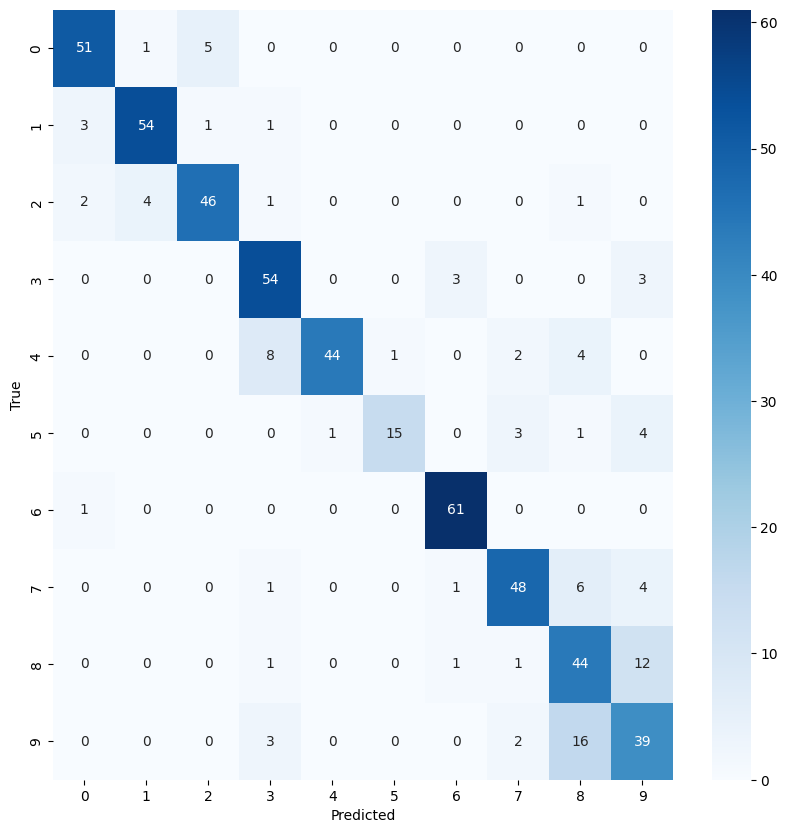

In [5]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, test_dataloader)